In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import directed_graphs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from directed_graphs.diffusion_flow_embedding import affinity_matrix_from_pointset_to_pointset

In [3]:
from collections import OrderedDict

def FlowArtist(dim = 2, shape = [2,4,8,4,2], device = torch.device('cpu')):
    # Function to create tailored flow artist
    
    FA = nn.Sequential()
    
    d_len = len(shape)*2
    d = OrderedDict()
    d[str(0)] = nn.Linear(shape[0], shape[1])
    for i in range(1,d_len-3):
        if i%2 == 1:
            d[str(i)] = nn.LeakyReLU()
        else:
            d[str(i)] = nn.Linear(shape[int(i/2)], shape[int(i/2)+1])
    
    # create MLP
    FA = nn.Sequential(d) # d is an OrderedDictionary
        
    return FA

In [4]:
from collections import OrderedDict

def FlowArtist(dim = 2, shape = [2,4,8,4,2], device = torch.device('cpu')):
    # Function to create tailored flow artist
    
    FA = nn.Sequential()
    
    d_len = len(shape)*2
    d = OrderedDict()
    d[str(0)] = nn.Linear(shape[0], shape[1])
    for i in range(1,d_len-3):
        if i%2 == 1:
            d[str(i)] = nn.LeakyReLU()
        else:
            d[str(i)] = nn.Linear(shape[int(i/2)], shape[int(i/2)+1])
    
    # create MLP
    FA = nn.Sequential(d) # d is an OrderedDictionary
        
    return FA

In [5]:
class FeedForwardReLU(nn.Module):
    def __init__(self, shape):
        super(FeedForwardReLU, self).__init__()
        d_len = len(shape) * 2
        d = OrderedDict()
        d[str(0)] = nn.Linear(shape[0], shape[1])
        for i in range(1, d_len - 3):
            if i % 2 == 1:
                d[str(i)] = nn.LeakyReLU()
            else:
                d[str(i)] = nn.Linear(shape[int(i / 2)], shape[int(i / 2) + 1])
        # create MLP
        self.FA = nn.Sequential(d)

    def forward(self, X):
        return self.FA(X)

## Loss Functions

In [6]:
def diffusion_map_loss(P_graph, embedded_points):
  num_nodes = P_graph.shape[0]
  D_graph = torch.cdist(P_graph, P_graph)
  D_embedding = torch.cdist(embedded_points, embedded_points)
  loss = torch.norm(D_graph - D_embedding)**2 / (num_nodes**2)
  return loss

def near_neighbors_tensor(points, affinity_matrix, k):
    # returns n x k (neighbors) x dimensions Tensor
    A = affinity_matrix
    n = A.shape[0]
    d = points.size()[1]
    _, indices = torch.topk(A, k)
    
    ret = torch.empty(size=(n,k,d)).to(device)
    
    for i in range(indices.size()[0]):
        for j in range(indices.size()[1]):
            index = indices[i][j]
            ret[i][j] = points[index]
    
    return ret

def flow_neighbor_loss(points, near_neighbors, encoder, flow_artist):
    
    k = near_neighbors.shape[1]
    embedded_points = encoder(points)
    embedded_points = embedded_points[:,None,:].repeat(1,k,1)
    
    big_mat = encoder(near_neighbors) - embedded_points - flow_artist(embedded_points)
    norms = torch.linalg.norm(big_mat, dim = 2)
    
    return torch.sum(norms)

## Embedder Class

In [36]:
class FlowEmbedder(torch.nn.Module):
    def __init__(
        self,
        X,
        flow,
        sigma_graph=0.5,
        flow_strength_graph=5,
        embedding_dimension=2,
        learning_rate=1e-3,
        FAShape=(2, 4, 8, 4, 2),
        EncShape=(3, 4, 8, 4, 2),
        decoder=None,
        labels=None,
        loss_weights=None,
        knn = 10,
        device=torch.device("cpu"),
    ):
        # initialize parameters
        super(FlowEmbedder, self).__init__()

        # generate default parameters
        embedder = (
            FeedForwardReLU(shape=EncShape)
        )
        loss_weights = (
            {
                "points": 1,
                "flow": 1,
                "smoothness": 0,
                "CLL": 0,
            }
            if loss_weights is None
            else loss_weights
        )
        self.X = X
        self.flow = flow
        self.sigma_graph = sigma_graph
        self.nnodes = X.shape[0]
        self.data_dimension = X.shape[1]

        self.loss_weights = loss_weights
        self.labels = labels
        self.embedding_dimension = embedding_dimension
        # set device (used for shuffling points around during visualization)
        self.device = device

        """
        # Affinity Matrix in Ambient Space
        self.P_graph = affinity_matrix_from_pointset_to_pointset(
            X, X, flow, sigma=sigma_graph, flow_strength=flow_strength_graph
        )
        self.P_graph = F.normalize(self.P_graph, p=1, dim=1)
        """
        # Affinity Matrix in Ambient Space
        x = X.to('cpu')
        f = flow.to('cpu')
        p = affinity_matrix_from_pointset_to_pointset(
            x, x, f, sigma=sigma_graph, flow_strength=flow_strength_graph
        )
        p = F.normalize(p, p=1, dim=1)
        self.P_graph = p.to(device)
        
        # Ambient space points neighbors
        self.knn = knn
        self.near_neighbors = near_neighbors_tensor(self.X, self.P_graph, self.knn)
        
        # Flow field
        self.FlowArtist = FlowArtist(dim = 2, 
                                     shape = FAShape, 
                                     device = torch.device('cpu')
        ).to(self.device)

        # Autoencoder to embed the points into a low dimension
        
        self.embedder = embedder
        if decoder is not None:
            self.decoder = decoder.to(self.device)
        else:
            self.decoder = None

        # training ops
        self.optim = torch.optim.Adam(self.parameters(), lr=learning_rate)

        # split input data into batches

    def loss(self, epoch, total):
        # embed points
        self.embedded_points = self.embedder(self.X)
        # compute diffusion loss on embedded points
        
        #"""
        # compute point embedding loss according to diffusion maps
        diffmap_loss = diffusion_map_loss(self.P_graph, self.embedded_points)
        self.losses["points"].append(diffmap_loss)
        #"""
        
        beta = (1/(1+np.exp(-(epoch-total)/(total/3))))*2*10e-5
        # beta = 10e-5
        
        #"""
        # compute flow field loss
        flow_loss = flow_neighbor_loss(self.X, self.near_neighbors, self.embedder, self.FlowArtist)*beta
        self.losses["flow"].append(flow_loss/beta)
        #"""
        
        """
        if epoch < 2000:
            loss = diffmap_loss
        else:
             loss = diffmap_loss + flow_loss
        """
        
        """
        if epoch < 2000:
            loss = diffmap_loss
        elif epoch < 4000:
             loss = diffmap_loss + flow_loss
        else:
            loss = 0.5*diffmap_loss + flow_loss
        """
        
        loss = diffmap_loss + flow_loss
        
        return loss

    def visualize_points(self, labels=None):
        embedded_points = self.embedder(X)
        
        xmin = float(torch.min(embedded_points[:,0]))
        xmax = float(torch.max(embedded_points[:,0]))
        ymin = float(torch.min(embedded_points[:,1]))
        ymax = float(torch.max(embedded_points[:,1]))
        
        gridxmin = xmin - (xmax-xmin)*0.2
        gridxmax = xmax + (xmax-xmin)*0.2
        gridymin = ymin - (ymax-ymin)*0.2
        gridymax = ymax + (ymax-ymin)*0.2
        
        x_grid = torch.arange(gridxmin, gridxmax, (gridxmax-gridxmin)/20)
        y_grid = torch.arange(gridymin, gridymax, (gridymax-gridymin)/20)
        
        grid = []
        
        for i in range(20):
            for j in range(20):
                grid.append([x_grid[i], y_grid[j]])
        
        grid = torch.tensor(grid).float().to(device)
        flow = self.FlowArtist(grid)
        
        plt.scatter(embedded_points[:,0].cpu().detach(), embedded_points[:,1].cpu().detach(), c=labels)
        plt.quiver(grid[:,0].cpu().detach(),grid[:,1].cpu().detach(),flow[:,0].cpu().detach(),flow[:,1].cpu().detach())
        plt.show()

    def visualize_loss(self, loss_type="total"):
        # diffusion_loss,reconstruction_loss, smoothness_loss
        x = []
        k = ""
        losses = {}
        for key in self.losses.keys():
            losses[key] = []
            k = key
        losses["total"] = []
        for i in range(len(self.losses["points"])):
            x.append(i)
            for key in self.losses.keys():
                try:
                    losses[key].append(self.losses[key][i].detach().cpu().numpy())
                except:
                    losses[key].append(0)
        if loss_type == "all":
            for key in self.losses.keys():
                plt.plot(x, losses[key])
            plt.legend(self.losses.keys(), loc="upper right")
            plt.title("loss")
        else:
            plt.plot(x, losses[loss_type])
            plt.title(loss_type)
        
    def fit(self, n_steps=1000):
        # train Flow Embedder on the provided graph
        self.train()
        # reset losses
        self.losses = {}
        for k in self.loss_weights.keys():
            self.losses[k] = []
        # self.weight_of_flow = 0
        for step in trange(n_steps):
            self.optim.zero_grad()
            # compute loss
            loss = self.loss(step,n_steps)
            if loss.isnan():
                print("Final loss was nan")
                raise NotImplementedError
            # compute gradient and step backwards
            loss.backward()
            self.optim.step()
            # print progress report after every 500 epochs
            #"""
            if step % 250 == 0:
                print(f"EPOCH {step}.")
                self.visualize_points(labels)
            #"""
            # TODO: Criteria to automatically end training
        # print("Exiting training with loss ",loss)
        # return self.embedded_points, self.FlowArtist, self.losses

## RNA Velocity

Call one of the following and input returned object into `rnavelo` or `rnavelo_pcs` to get data, flows, labels (and n_pcs) in processed form.

- `scvelo.datasets.pancreas()`
- `scvelo.datasets.dentategyrus`
- `scvelo.datasets.forebrain`
- `scvelo.datasets.dentategyrus_lamanno`
- `scvelo.datasets.gastrulation`
- `scvelo.datasets.gastrulation_e75`
- `scvelo.datasets.gastrulation_erythroid`
- `scvelo.datasets.bonemarrow`
- `scvelo.datasets.pbmc68k`
- `scvelo.datasets.simulation`

In [8]:
import scvelo as scv
import numpy as np
import torch

def add_labels(clusters):
    cluster_set = set(clusters)
    d = {cluster: i for i, cluster in enumerate(cluster_set)}
    labels = np.array([d[cluster] for cluster in clusters])
        
    return labels

def rnavelo(adata):
    #preprocess data and calculate rna velocity
    scv.pp.filter_and_normalize(adata)
    scv.pp.moments(adata)
    scv.tl.velocity(adata, mode='stochastic')
    
    X = torch.tensor(adata.X.todense())
    flows = torch.tensor(adata.layers["velocity"])
    labels = add_labels(adata.obs["clusters"])
        
    return X, flows, labels

def rnavelo_pcs(adata):
    scv.pp.filter_and_normalize(adata)
    scv.pp.moments(adata)
    scv.tl.velocity(adata, mode='stochastic')
    
    # calculate velocity pca and display pca plot (2 dimensions)
    scv.tl.velocity_graph(adata)
    scv.pl.velocity_embedding_stream(adata, basis='pca')
    
    X = torch.tensor(adata.obsm["X_pca"])
    flows = torch.tensor(adata.obsm["velocity_pca"])
    labels = add_labels(adata.obs["clusters"])
    n_pcs = X.shape[1]
    
    return X, flows, labels, n_pcs

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:18) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:10) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:26) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/36 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:50) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


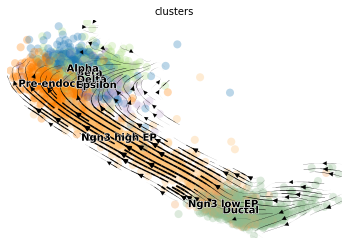

In [9]:
adata = scv.datasets.pancreas()
X, flows, labels, n_pcs  = rnavelo_pcs(adata)

In [10]:
print(device)
X = torch.tensor(adata.obsm["X_pca"])
flow = torch.tensor(adata.obsm["velocity_pca"])
X = X.float().to(device)
flow = flow.float().to(device)
print(X.shape[1])

cuda
50


In [37]:
FE = FlowEmbedder(X,
                  flow,
                  FAShape=(2, 4, 8, 4, 2),
                  EncShape=(50, 25, 12, 6, 3, 2),
                  knn = 10,
                  labels = labels,
                  device = device).to(device)

  0%|          | 0/5000 [00:00<?, ?it/s]

EPOCH 0.


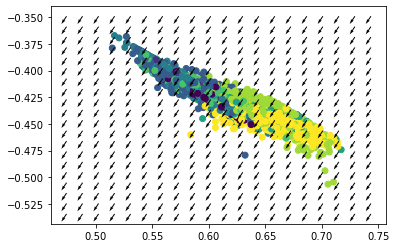

  5%|▍         | 248/5000 [00:04<01:16, 62.08it/s]

EPOCH 250.


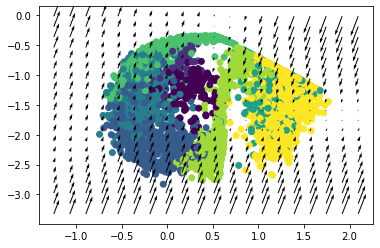

 10%|▉         | 497/5000 [00:09<01:12, 61.93it/s]

EPOCH 500.


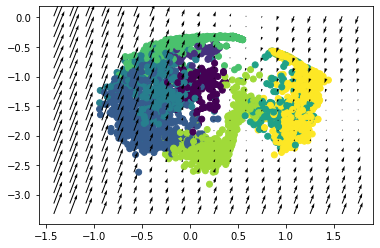

 15%|█▍        | 749/5000 [00:13<01:08, 61.80it/s]

EPOCH 750.


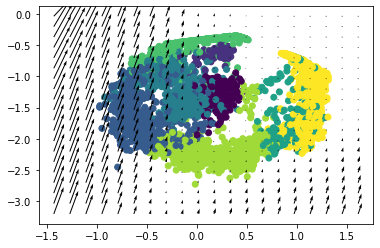

 20%|█▉        | 998/5000 [00:18<01:04, 61.98it/s]

EPOCH 1000.


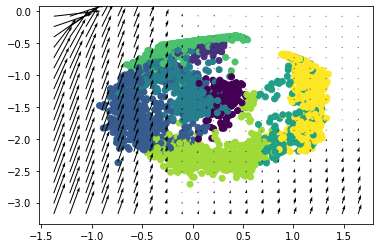

 25%|██▌       | 1250/5000 [00:23<01:00, 62.20it/s]

EPOCH 1250.


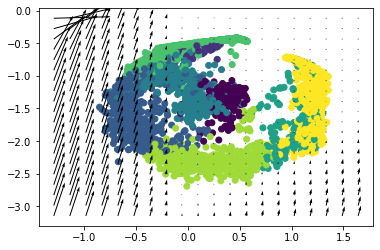

 30%|███       | 1500/5000 [00:27<00:56, 61.84it/s]

EPOCH 1500.


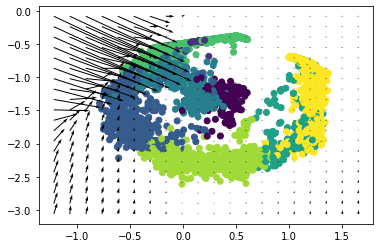

 35%|███▌      | 1750/5000 [00:32<00:52, 61.89it/s]

EPOCH 1750.


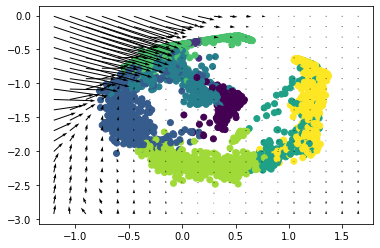

 40%|████      | 2000/5000 [00:36<00:48, 61.45it/s]

EPOCH 2000.


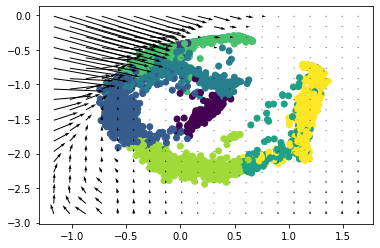

 45%|████▌     | 2250/5000 [00:41<00:44, 62.05it/s]

EPOCH 2250.


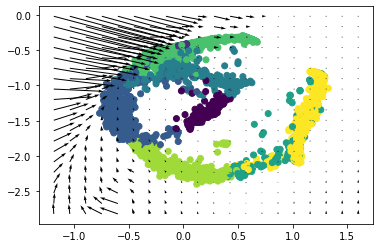

 50%|█████     | 2500/5000 [00:46<00:40, 61.91it/s]

EPOCH 2500.


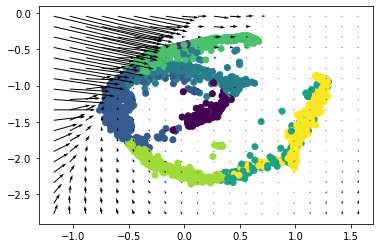

 53%|█████▎    | 2665/5000 [00:49<00:37, 61.55it/s]

In [ ]:
FE.fit(n_steps = 5000)

In [ ]:
FE.visualize_points(labels)

In [ ]:
FE.visualize_loss("flow")